In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf

In [12]:
data_path = "/kaggle/input/heart-sound-database/heart_sound"

In [13]:
tarin_data = data_path +"/train/"
val_data   = data_path + "/val/"
train_healthy_data   = tarin_data + '/healthy/'
train_unhealthy_data = tarin_data + '/unhealthy/'
val_healthy_data     = val_data   + '/healthy/'
val_unhealthy_data   = val_data   + '/unhealthy/'

In [14]:
print(os.listdir(data_path))

['val', 'train']


In [15]:
print(len(os.listdir(train_healthy_data))) #length of healthy training sounds
print(len(os.listdir(train_unhealthy_data))) #length of unhelathy training sounds 
print('TOTAL TRAIN SOUNDS:', len(os.listdir(train_healthy_data)) + len(os.listdir(train_unhealthy_data)))

2575
665
TOTAL TRAIN SOUNDS: 3240


## In this part I played a random sample of healthy data

In [17]:
# Choose random soud from healthy folder
random_healthy= np.random.randint(0,len(os.listdir(train_healthy_data))) 
healthy_sound = os.listdir(train_healthy_data)[random_healthy]
healthy_sound_address = train_healthy_data+healthy_sound
healthy_sound_sample,sample_rate = librosa.load(healthy_sound_address)
ipd.Audio(healthy_sound_sample,rate=sample_rate)

### Waveform

Sound is the pressure of air propagates to our ear. Digital audio file is gotten from a sound sensor that can detects sound waves and converting it to electrical signals.


Specifically, it's telling us about the wave's displacement, and how it changes over time.


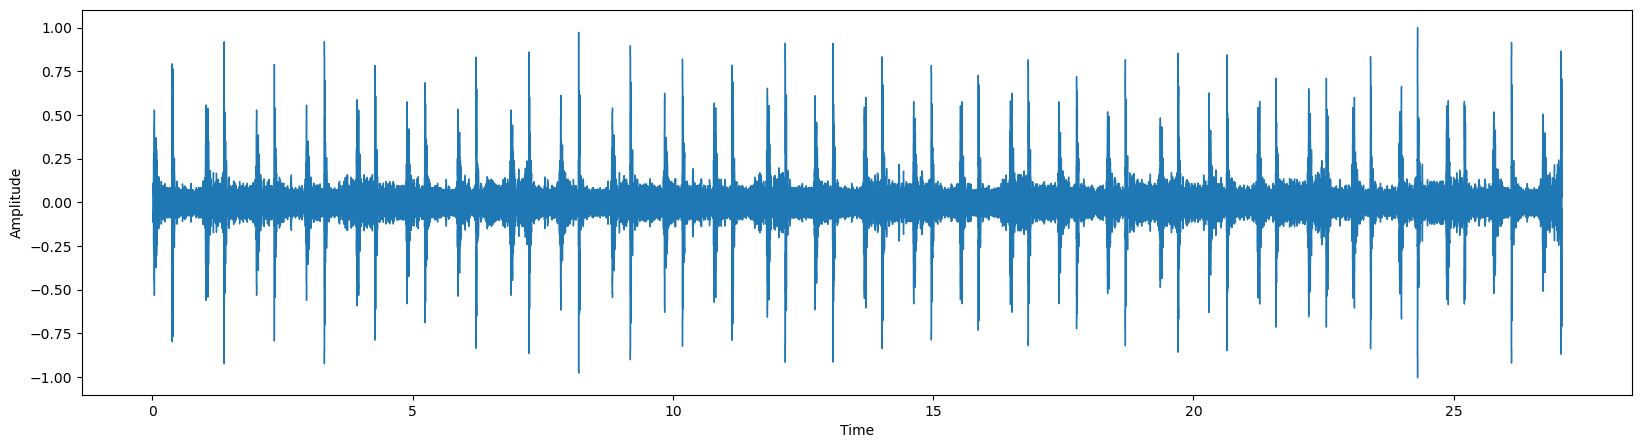

In [19]:
plt.figure(figsize=(20,5))
librosa.display.waveshow(healthy_sound_sample, sr = sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

X axis, represents time. In this case, our graph is showing a 28-second interval.
Y-axis measures displacement of air molecules.This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  

### Spectrum

A sound spectrum is a representation of a sound – usually a short sample of a sound – in terms of the amount of vibration at each individual frequency. It is usually presented as a graph of either power or pressure as a function of frequency. The power or pressure is usually measured in decibels and the frequency is measured in vibrations per second (or hertz, abbreviation Hz) or thousands of vibrations per second (kilohertz, abbreviation kHz).

The spectrum expresses the frequency composition of the sound and is obtained by analyzing the sound. A sound spectrum is usually represented in a coordinate plane where the frequency f is plotted along the axis of abscissas and the amplitude A, or intensity, of a harmonic component with a given frequency is plotted along the axis of ordinates.

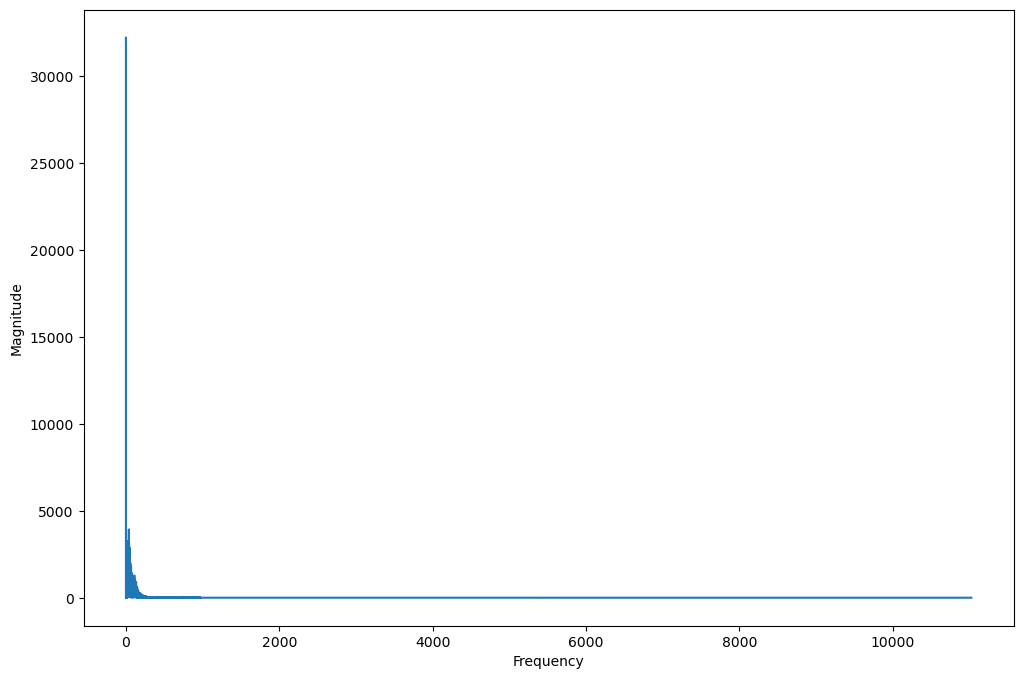

In [20]:
fft_healthy = np.fft.fft(healthy_sound_sample)
magnitude_healthy = np.abs(fft_healthy)
freq_healthy = np.linspace(0,sample_rate, len(magnitude_healthy)) 
half_freq = freq_healthy[:int(len(freq_healthy)/2)]
half_magnitude = magnitude_healthy[:int(len(freq_healthy)/2)]

plt.figure(figsize=(12,8))
plt.plot(half_freq,half_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Spectogram

For us, as human, we sense a sound not only on a particular time by its intensity, but also by its pitch. The pitch is the frequency of the sound - higher pitch corresponding to higher frequency and vice versa. So, to have a representation which is closer to our brain, we can add another dimension - the frequency - to our representation, which is the Spectrogram.


A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

Spectrograms are used extensively in the fields of music, linguistics, sonar, radar, speech processing,seismology, and others. Spectrograms of audio can be used to identify spoken words phonetically, and to analyse the various calls of animals.it can be generated by an optical spectrometer, a bank of band-pass filters, by Fourier transform or by a wavelet transform.

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

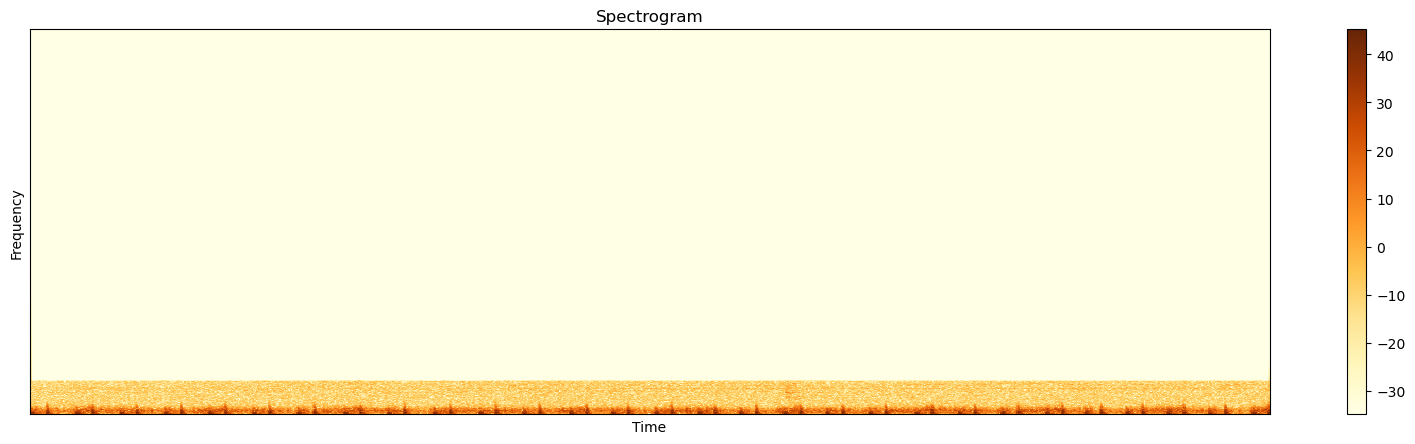

In [21]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft_healthy = librosa.stft(healthy_sound_sample, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft_healthy)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# display spectrogram
plt.figure(figsize=(20,5))
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.set_cmap("YlOrBr")
plt.title("Spectrogram")

we have an image that represents a sound. X-axis is for time, y-axis is for frequency and the color is for intensity

### MFCCs

We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input. MFCC is the widely used technique for extracting the features from the audio signal.

in sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression.



**MFCCs are commonly derived as follows:**

1- Take the Fourier transform of (a windowed excerpt of) a signal.

2- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.

3- Take the logs of the powers at each of the mel frequencies.

4- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.

5- The MFCCs are the amplitudes of the resulting spectrum.

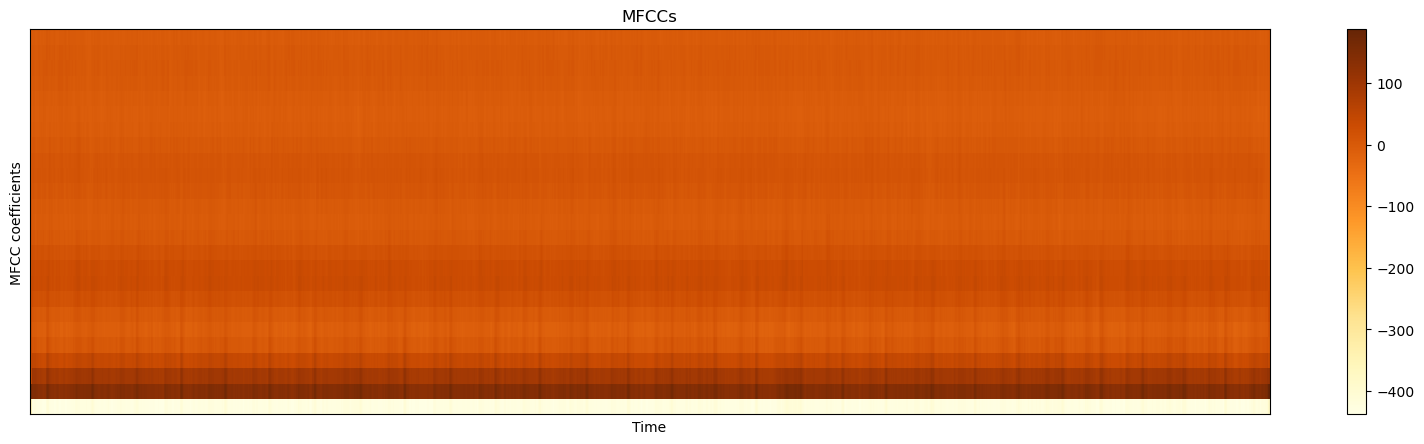

In [28]:
# MFCCs
# extract 25 MFCCs
MFCCs = librosa.feature.mfcc(y=healthy_sound_sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)

# display MFCCs
plt.figure(figsize=(20,5))
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.set_cmap("YlOrBr")
plt.title("MFCCs")

# show plots
plt.show()

## Unhealthy sound

In [29]:
# Choose random soud from unhealthy folder
random_unhealthy= np.random.randint(0,len(os.listdir(train_unhealthy_data))) 
unhealthy_sound = os.listdir(train_unhealthy_data)[random_unhealthy]
unhealthy_sound_address = train_unhealthy_data+unhealthy_sound
unhealthy_sound_sample,sample_rate = librosa.load(unhealthy_sound_address)
ipd.Audio(unhealthy_sound_sample,rate=sample_rate)

### Waveform

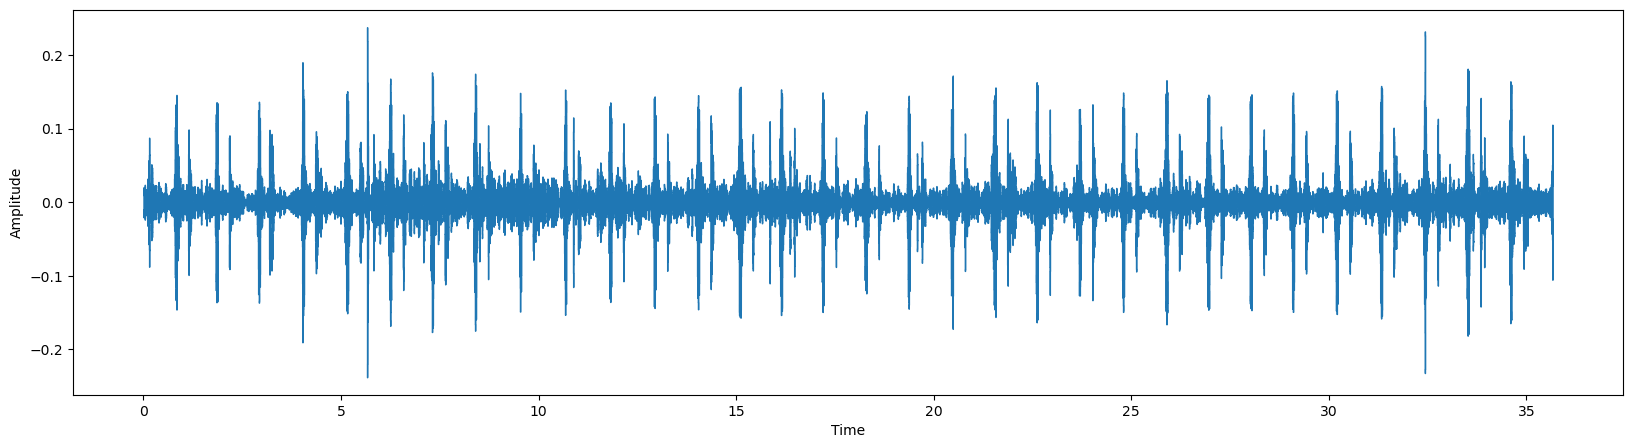

In [30]:
plt.figure(figsize=(20,5))
librosa.display.waveshow(unhealthy_sound_sample, sr = sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Spectrum

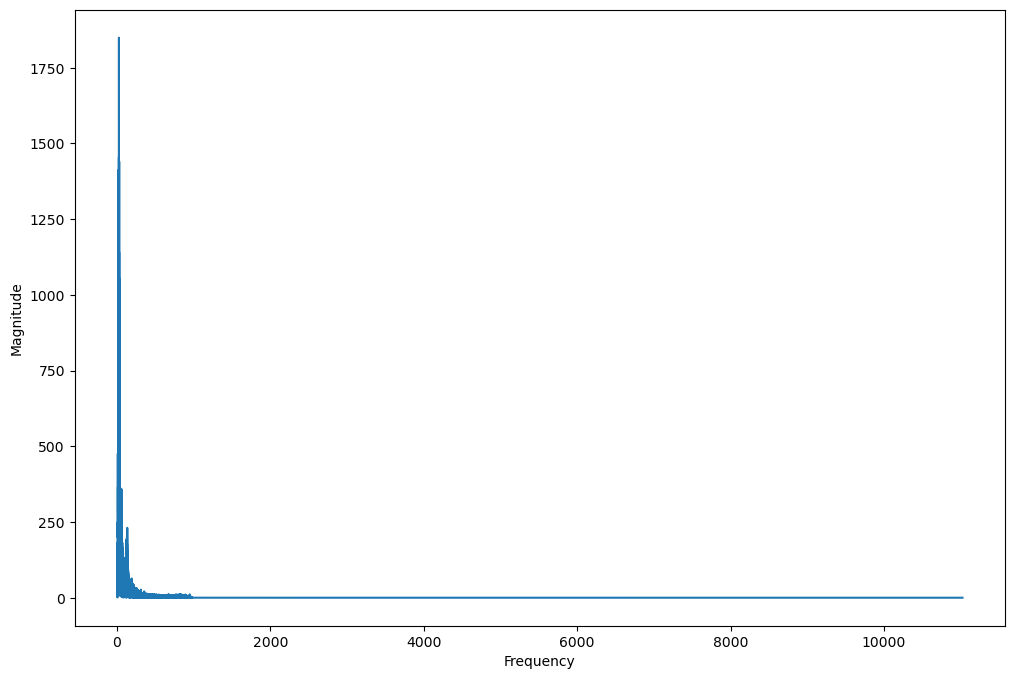

In [31]:
fft_unhealthy = np.fft.fft(unhealthy_sound_sample)
magnitude_unhealthy = np.abs(fft_unhealthy)
freq_unhealthy = np.linspace(0,sample_rate, len(magnitude_unhealthy)) 
half_freq = freq_unhealthy[:int(len(freq_unhealthy)/2)]
half_magnitude = magnitude_unhealthy[:int(len(freq_unhealthy)/2)]

plt.figure(figsize=(12,8))
plt.plot(half_freq,half_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Spectogram

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

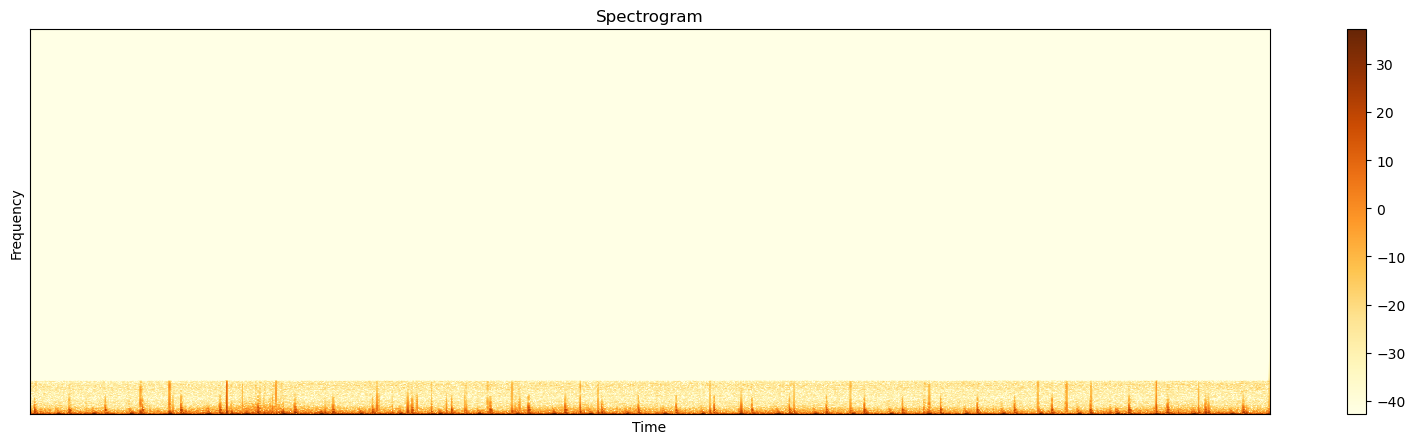

In [32]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft_unhealthy = librosa.stft(unhealthy_sound_sample, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft_unhealthy)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# display spectrogram
plt.figure(figsize=(20,5))
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.set_cmap("YlOrBr")
plt.title("Spectrogram")

### MFCCs

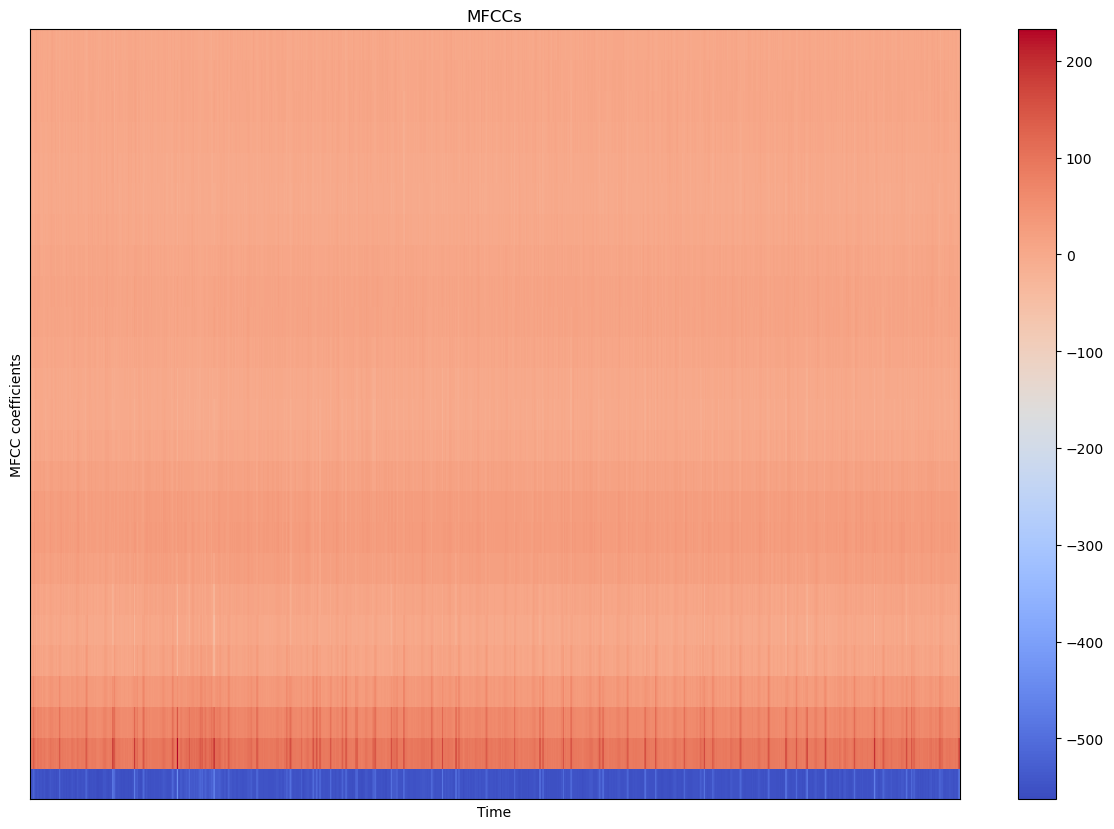

In [33]:
# MFCCs
# extract 25 MFCCs
MFCCs = librosa.feature.mfcc(y=unhealthy_sound_sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)

# display MFCCs
plt.figure(figsize=(15,10))
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
#plt.set_cmap("YlOrBr")
plt.title("MFCCs")

# show plots
plt.show()

# Loading data

In [63]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    input_length=sr*duration

    data = []
    for file_name in file_names:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X,size=input_length)                          
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=25).T,axis=0)                   
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
    return data

#  preprocessing : 

## *Encoding*

In [58]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['healthy','unhealthy']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'healthy': 0, 'unhealthy': 1}
 
{0: 'healthy', 1: 'unhealthy'}


In [64]:
# KHz
SAMPLE_RATE = 22050
# seconds
MAX_SOUND_CLIP_DURATION=10
healthy_files = fnmatch.filter(os.listdir(train_healthy_data), '*.wav')
healthy_sounds = load_file_data (folder=train_healthy_data, file_names = healthy_files, duration=MAX_SOUND_CLIP_DURATION)
healthy_labels = [0 for items in healthy_files]



print ("loaded dataset")


load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/a0032.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e00573.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e01532.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/a0211.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/a0409.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e00658.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e01089.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e00482.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/b0310.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/a0241.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/e00876.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//healthy/b0178.wa

In [65]:
unhealthy_files = fnmatch.filter(os.listdir(train_unhealthy_data), '*.wav')
unhealthy_sounds = load_file_data(folder=train_unhealthy_data,file_names=unhealthy_files, duration=MAX_SOUND_CLIP_DURATION)
unhealthy_labels = [1 for items in unhealthy_sounds]


load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/a0142.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/a0314.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/b0086.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/c0001.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/a0322.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/a0225.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/e01382.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/e01623.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/e01719.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/b0081.wav
load file  /kaggle/input/heart-sound-database/heart_sound/train//unhealthy/b0030.wav
load file  /kaggle/input/heart-sound-database/heart_sound/trai

In [66]:
# test files
val_healthy_files = fnmatch.filter(os.listdir(val_healthy_data), '*.wav')
val_healthy_sounds = load_file_data(folder=val_healthy_data,file_names=val_healthy_files, duration=MAX_SOUND_CLIP_DURATION)
val_healthy_labels = [0 for items in val_healthy_sounds]

val_unhealthy_files = fnmatch.filter(os.listdir(val_unhealthy_data), '*.wav')
val_unhealthy_sounds = load_file_data(folder=val_unhealthy_data,file_names=val_unhealthy_files, duration=MAX_SOUND_CLIP_DURATION)
val_unhealthy_labels = [1 for items in val_unhealthy_sounds]


print ("loaded test dataset")


load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/a0032.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/e00009.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/b0029.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/b0062.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/e00016.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/a0035.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/e00022.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/a0129.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/a0050.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/e00043.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/c0006.wav
load file  /kaggle/input/heart-sound-database/heart_sound/val//healthy/a0027.wav
load file  /kaggle/input

## *concatenation*

In [67]:
x_data = np.concatenate((healthy_sounds, unhealthy_sounds))

y_data = np.concatenate((healthy_labels,unhealthy_labels))

test_x = np.concatenate((val_healthy_sounds,val_unhealthy_sounds))
test_y = np.concatenate((val_healthy_labels,val_unhealthy_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  3240 301


## *train_test_validation split*



In [68]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

seed = 100
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

In [69]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (3240,)
data size of the array: : 3240
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  25920
0

audio data shape:  (3240, 25, 1)
data size of the array: : 81000
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  324000

training data shape:  (2073, 25, 1)
training label shape:  (2073, 2)

validation data shape:  (519, 25, 1)
validation label shape:  (519, 2)

test data shape:  (648, 25, 1)
test label shape:  (648, 2)


# LSTM Model

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
#from tensorflow.keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [72]:
model = Sequential()
model.add(Bidirectional(LSTM(128, dropout=0.05, recurrent_dropout=0.20, return_sequences=True), input_shape = (25,1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Flatten())

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['acc'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 25, 256)          133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 25, 128)           32896     
                                                                 
 dense_1 (Dense)             (None, 25, 64)            8256      
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 25, 32)            2080      
                                                                 
 dense_3 (Dense)             (None, 25, 32)            1056      
                                                        

In [73]:
print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=16, 
                  epochs=20,
                  validation_data=(x_val, y_val)) 

print ("training finised!")

training started..... please wait.
Epoch 1/20
130/130 [==============================] - 16s 72ms/step - loss: 0.4841 - acc: 0.7959 - val_loss: 0.4441 - val_acc: 0.7630
Epoch 2/20
130/130 [==============================] - 8s 65ms/step - loss: 0.4086 - acc: 0.7969 - val_loss: 0.4087 - val_acc: 0.7630
Epoch 3/20
130/130 [==============================] - 10s 79ms/step - loss: 0.3893 - acc: 0.8022 - val_loss: 0.3967 - val_acc: 0.7958
Epoch 4/20
130/130 [==============================] - 8s 65ms/step - loss: 0.3831 - acc: 0.8205 - val_loss: 0.3826 - val_acc: 0.8054
Epoch 5/20
130/130 [==============================] - 8s 64ms/step - loss: 0.3690 - acc: 0.8316 - val_loss: 0.3761 - val_acc: 0.8073
Epoch 6/20
130/130 [==============================] - 9s 68ms/step - loss: 0.3604 - acc: 0.8432 - val_loss: 0.3747 - val_acc: 0.7958
Epoch 7/20
130/130 [==============================] - 9s 67ms/step - loss: 0.3505 - acc: 0.8461 - val_loss: 0.3541 - val_acc: 0.8131
Epoch 8/20
130/130 [============

<Axes: >

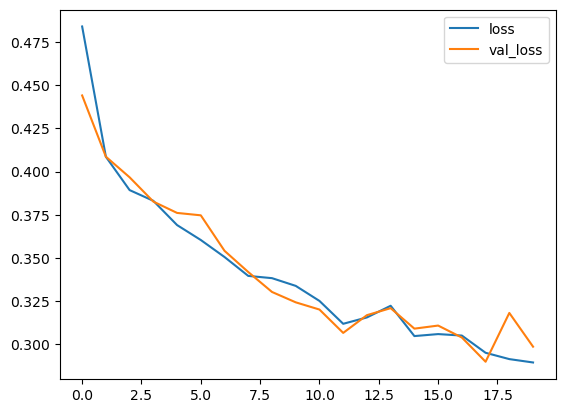

In [74]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

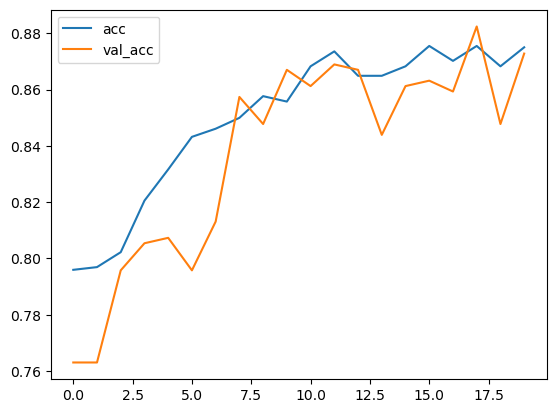

In [75]:
losses[['acc','val_acc']].plot()

# prediction


In [76]:
# make a prediction
y_pred = model.predict(x_test, batch_size=5)
#check scores
scores = model.evaluate(x_test, y_test)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

21/21 [==============================] - 0s 12ms/step - loss: 0.2781 - acc: 0.8750
Model evaluation accuracy:  88 %
